# PyTorch Cart-Pole tutorial
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [8]:
import gym
import math
import random
import numpy as np
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
plt.ion() # turn on interactive mode
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notes on rendering (specific to Jupyter Notebook)
* env.render(mode='rgb_array') only works with pyglet v1.2.4 ($pip install pyglet==1.2.4) and not newer versions

* to prevent render from opening in a new window, open python notebook using xvfb ($xvfb-run -s "-screen 0 1400x900x24" jupyter notebook)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


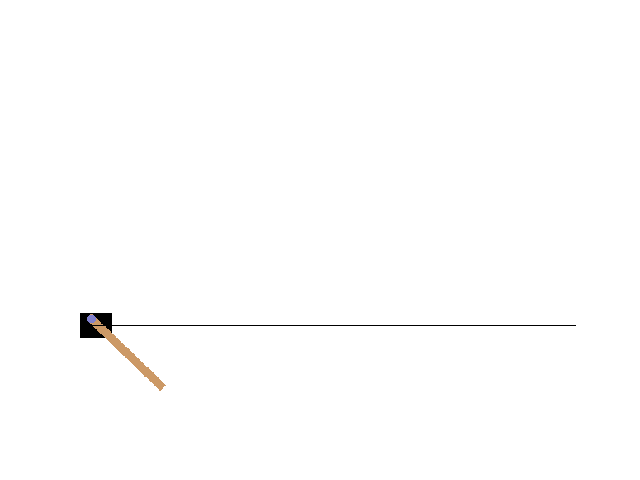

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


In [18]:
env = gym.make('CartPole-v0').unwrapped
observation = env.reset()

fig = plt.figure('Cart pole')
plt.axis('off')
img = plt.imshow(env.render(mode='rgb_array'))

for _ in range(500):
    x = env.render(mode='rgb_array') # in rgb_array mode this returns a numpy array
    
    # update the figure to show new state
    img.set_data(x) # this is a lot faster than calling imshow every time
    fig.canvas.draw()
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

### Replay memory
Stores transitions. randomly sampling these decorrelates them (stabilizes, improves training)

In [19]:
Transition = namedtuple('Transition', ['state', 'action', 'new_state', 'reward'])

class ReplayMemory(object):
    def __init__(self, capacity):
        # circular-buffer-like, with length of list expanding up to capacity, and then overwriting oldest entries
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        '''Adds a transition to memory'''
        # if memory hasn't stored max number of states, expand size
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        # store transition in memory. if memory is at capacity, overwrite oldest stored transition
        self.memory[self.position] = Transition(*args)
        # increment position in memory queue
        self.position = (self.position + 1) % self.capacity 
        
    def sample(self, batch_size):
        '''Returns batch_size number of randomly selected stored transitions'''
        return random.sample(self.memory, batch_size)
    
    # overload len()
    def __len__(self):
        return len(self.memory)

## DQN algorithm
note: environment is deterministic.

Want to train a policy $\pi(s)$ (mapping from state to action) that maximizes the discounted return $R_t = \Sigma_{t}^{T}\gamma^t r_t$, where $\gamma \in [0,1]$ is the discount factor, and $r_t$ is the reward received at time $t$

Want to find an optimal value function $Q^*(s,a)$ which quantifies the value (expected return) of taking action $a$ from state $s$. It is then easy to find the optimal policy $\pi^*(s) = argmax_aQ^*(s,a)$, i.e. to always choose the action with maximum expected return.

Approximate $Q^*$ using a neural network.

The value function $Q$ obeys the deterministic Bellman equation $Q^{\pi}(s,a) = r + \gamma Q^{\pi}(s',\pi(s))$, i.e. the state-action value is equal to the reward received from taking action $a$ plus the discounted value of reaching the new state $s'$

We want $Q^{\pi}$ to converge to $Q^*$, so the loss is defined using the temporal difference error $\delta = Q^{\pi}(s,a) - (r + \gamma max_a Q^{\pi}(s',a))$

Use Huber loss over batch $B$ sampled from replay memory: $L = \frac{1}{|B|}\Sigma L(\delta)$ where $L{\delta} = \frac{1}{2}\delta^2$ if $|\delta| < 1$, $|\delta| - \frac{1}{2}$ otherwise

### Q-network
Train CNN that takes difference between current and previous frames (note: what about acceleration?) as inputs, and outputs two scalars: $Q(s,right)$ and $Q(s,left)$

In [ ]:
# network has three conv/batchnorm/relu layers, followed by a fully-connected output layer
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=5, stride=2),
                        nn.BatchNorm2d(16))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16, 32, kernel_size=5, stride=2),
                        nn.BatchNorm2d(32))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(32, 32, kernel_size=5, stride=2),
                        nn.BatchNorm2d(32))
        self.fc_out = nn.Linear(448, 2) # how do you come up with # of input features?
        
    def forward(self, x):
        x = nn.relu(self.layer1(x))
        x = nn.relu(self.layer2(x))
        x = nn.relu(self.layer3(x))
        x = x.view(x.size(0), -1) # reshape into single vector
        return self.fc_out(x)

In [16]:
# screen capture
def get_screen():
    screen = env.render(mode='rgb_array')
    screen = screen.transpose(2,0,1) # switch from (width x height x nChannel) to (nChannel, width, height)
    
    
get_screen()

(3, 400, 600)
